In [2]:
!nvidia-smi

Wed Nov 20 09:30:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.13                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              3W /   70W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import tempfile
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [17]:
# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the labels/classes

labels = {
    r"C:\Users\RAMAR BOSE\Downloads\Satellite Image data\cloudy": "Cloudy",
    r"C:\Users\RAMAR BOSE\Downloads\Satellite Image data\desert": "Desert",
    r"C:\Users\RAMAR BOSE\Downloads\Satellite Image data\green_area": "Green_Area",
    r"C:\Users\RAMAR BOSE\Downloads\Satellite Image data\water": "Water",
}

# Validate folder paths
for folder in labels:
    if not os.path.exists(folder):
        print(f"Warning: The folder {folder} does not exist.")
        continue

    # Process each image in the folder
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        if os.path.isfile(image_path):  # Only process files
            label = labels[folder]
            data = pd.concat([data, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

# Display the resulting DataFrame
print(data)


                                             image_path   label
0     C:\Users\RAMAR BOSE\Downloads\Satellite Image ...  Cloudy
1     C:\Users\RAMAR BOSE\Downloads\Satellite Image ...  Cloudy
2     C:\Users\RAMAR BOSE\Downloads\Satellite Image ...  Cloudy
3     C:\Users\RAMAR BOSE\Downloads\Satellite Image ...  Cloudy
4     C:\Users\RAMAR BOSE\Downloads\Satellite Image ...  Cloudy
...                                                 ...     ...
5626  C:\Users\RAMAR BOSE\Downloads\Satellite Image ...   Water
5627  C:\Users\RAMAR BOSE\Downloads\Satellite Image ...   Water
5628  C:\Users\RAMAR BOSE\Downloads\Satellite Image ...   Water
5629  C:\Users\RAMAR BOSE\Downloads\Satellite Image ...   Water
5630  C:\Users\RAMAR BOSE\Downloads\Satellite Image ...   Water

[5631 rows x 2 columns]


In [18]:
data.to_csv('image_dataset.csv', index=False)

In [19]:
df = pd.read_csv("image_dataset.csv")

In [20]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(255, 255),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\RAMAR BOSE\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 253, 253, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,494 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
history = model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25


C:\Users\RAMAR BOSE\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.6163 - loss: 0.8769 - val_accuracy: 0.8332 - val_loss: 0.3829
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.8127 - loss: 0.4591 - val_accuracy: 0.7737 - val_loss: 0.4567
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.8107 - loss: 0.4202 - val_accuracy: 0.7915 - val_loss: 0.4627
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.8519 - loss: 0.3829 - val_accuracy: 0.8110 - val_loss: 0.4235
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.8619 - loss: 0.3664 - val_accuracy: 0.8607 - val_loss: 0.3532
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8673 - loss: 0.3457

KeyboardInterrupt: 

In [25]:
num_samples = test_df.shape[0]
score = model.evaluate(test_generator, steps=num_samples//32+1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 419ms/step - accuracy: 0.8644 - loss: 0.3089


In [29]:
model.save('Modelenv.v1.h5')

In [30]:
model = load_model("Modelenv.v1.h5")

In [31]:
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']

In [32]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
predictions = model.predict(test_generator)
actual_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 416ms/step


In [35]:
cm = confusion_matrix(actual_labels, predicted_labels)

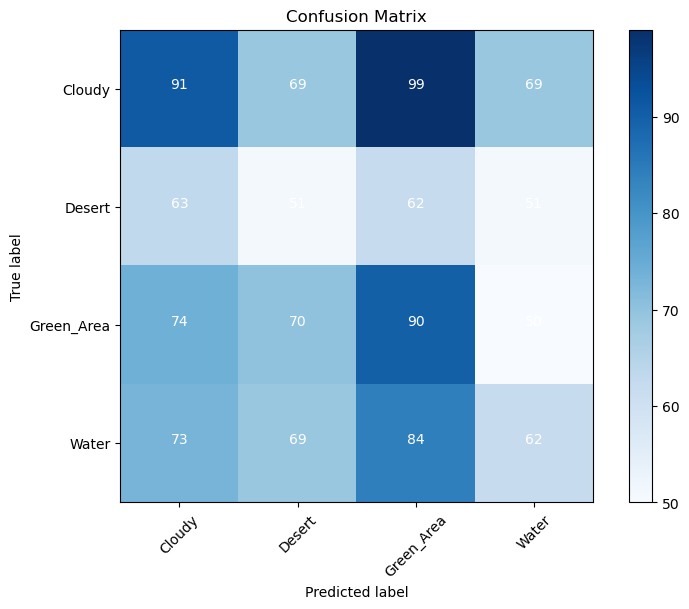

In [36]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()